# CSCI 4435/5435: Text Mining & Natural Language Processing
## Assignment 5: Using LLMs for Summarization (using tl;dr)
### Student: Miguel Guirao
### Aggie ID: 800699208

## Summary
0. Reference: [Amazon Review Summarization Using GPT-2 And PyTorch](https://www.nbshare.io/notebook/764386829/Amazon-Review-Summarization-Using-GPT-2-And-PyTorch/)
1. The news_summary dataset has two features and 98,401 examples. We will be using the "text" feature for training an LLM and "headlines" as True label.

In [23]:
# import the required libraries
import pandas as pd
import re
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, GPT2LMHeadModel
import torch.optim as optim
import transformers

In [ ]:
# Check the versions I am using
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {plt.__version__}")
print(f"Transformers: {transformers.__version__}")
#print(f": {}")

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using compute device: {device}")

Using compute device: cuda:0


## 1. Load dataset

In [3]:
news_df = pd.read_csv('news_summary.csv')
news_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 2. Data Preprocessing

In [4]:
newssummary_df = news_df['text'] + " TL;DR " + news_df['headlines']
newssummary_df.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
dtype: object

In [5]:
print(newssummary_df[0])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. TL;DR upGrad learner switches to career in ML & Al with 90% salary hike


In [6]:
print(newssummary_df[5])

Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre". TL;DR Rahat Fateh Ali Khan denies getting notice for smuggling currency


### In order to select a proper fixed length input, I get the lenghts of all reviews and create a boxplot. With the boxplot created I can easily see that the median input length is around 70 words, with a maximun of 80 words.
### I select 80 as the fixed length input.

In [16]:
newssummary_df_length = [len(review.split()) for review in newssummary_df] #/len(reviews)
print(min(newssummary_df_length), max(newssummary_df_length))

3 79


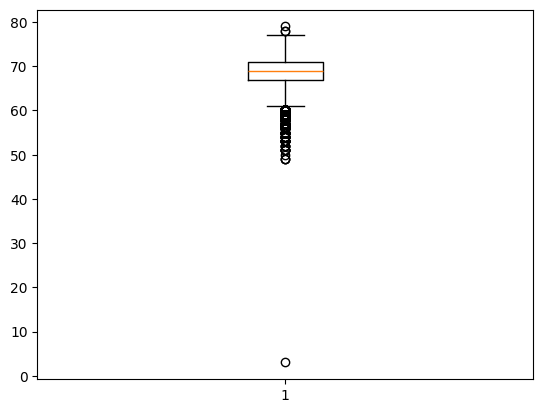

In [15]:
plt.boxplot(newssummary_df_length)
plt.show()

In [17]:
max_length = 80

## Setup and Training

In [ ]:
# AutoModelForCausalLM: https://huggingface.co/docs/trl/main/en/models#trl.AutoModelForCausalLMWithValueHead
# AutoModelForMaskedLM: 
# https://huggingface.co/docs/transformers/main/en/model_doc/gpt2#transformers.GPT2LMHeadModel

In [21]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
#model = AutoModelWithLMHead.from_pretrained("gpt2") # Deprecated. Options: AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM
model = AutoModelForCausalLM.from_pretrained("gpt2")
model = model.to(device)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

In [26]:
tokenizer.encode(" TL;DR ")

[24811, 26, 7707, 220]

In [27]:
extra_length = len(tokenizer.encode(" TL;DR ")) 

In [28]:
class ReviewDataset(Dataset):  
    def __init__(self, tokenizer, reviews, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.eos = self.tokenizer.eos_token
        self.eos_id = self.tokenizer.eos_token_id
        self.reviews = reviews
        self.result = []

        for review in self.reviews:
            # Encode the text using tokenizer.encode(). We add EOS at the end
            tokenized = self.tokenizer.encode(review + self.eos)
            
            # Padding/truncating the encoded sequence to max_len 
            padded = self.pad_truncate(tokenized)            

            # Creating a tensor and adding to the result
            self.result.append(torch.tensor(padded))

    def __len__(self):
        return len(self.result)


    def __getitem__(self, item):
        return self.result[item]

    def pad_truncate(self, name):
        name_length = len(name) - extra_length
        if name_length < self.max_len:
            difference = self.max_len - name_length
            result = name + [self.eos_id] * difference
        elif name_length > self.max_len:
            result = name[:self.max_len + 3]+[self.eos_id] 
        else:
            result = name
        return result

In [29]:
dataset = ReviewDataset(tokenizer, newssummary_df, max_length)

## (80 pts) Train a GPT model to perform summarization using tl;dr token.

In [30]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [31]:
def train(model, optimizer, dl, epochs):
    losses = []
    for epoch in range(epochs):
        for idx, batch in enumerate(dl):
             with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                batch = batch.to(device)
                output = model(batch, labels=batch)
                loss = output[0]
                loss.backward()
                losses.append(loss)
                optimizer.step()
                if idx % 50 == 0:
                    print("loss: %f, %d"%(loss, idx))
    return losses

In [32]:
start = time.time()
losses = train(model=model, optimizer=optimizer, dl=dataloader, epochs=1)
end = time.time()
print(f"Total training time: {(end-start):.3f} seconds.")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


loss: 3.652445, 0
loss: 3.132524, 50
loss: 3.032481, 100
loss: 2.824971, 150
loss: 2.726963, 200
loss: 2.815919, 250
loss: 2.828111, 300
loss: 2.755914, 350
loss: 2.808611, 400
loss: 2.787791, 450
loss: 2.685853, 500
loss: 2.761338, 550
loss: 2.745694, 600
loss: 2.816045, 650
loss: 2.839061, 700
loss: 2.768119, 750
loss: 2.689610, 800
loss: 2.737866, 850
loss: 2.561253, 900
loss: 2.795676, 950
loss: 2.877595, 1000
loss: 2.910626, 1050
loss: 2.716318, 1100
loss: 2.811880, 1150
loss: 2.680061, 1200
loss: 2.544855, 1250
loss: 2.729895, 1300
loss: 2.681533, 1350
loss: 2.649523, 1400
loss: 2.795129, 1450
loss: 2.692155, 1500
loss: 2.758815, 1550
loss: 2.592784, 1600
loss: 2.566441, 1650
loss: 2.598029, 1700
loss: 2.704322, 1750
loss: 2.548507, 1800
loss: 2.777221, 1850
loss: 2.664867, 1900
loss: 2.578642, 1950
loss: 2.525260, 2000
loss: 2.816991, 2050
loss: 2.672915, 2100
loss: 2.585320, 2150
loss: 2.727437, 2200
loss: 2.647789, 2250
loss: 2.735990, 2300
loss: 2.712736, 2350
loss: 2.595888,

## Review Summarization

In [34]:
def topk(probs, n=9):
    # The scores are initially softmaxed to convert to probabilities
    probs = torch.softmax(probs, dim= -1)
    
    # PyTorch has its own topk method, which we use here
    tokensProb, topIx = torch.topk(probs, k=n)
    
    # The new selection pool (9 choices) is normalized
    tokensProb = tokensProb / torch.sum(tokensProb)

    # Send to CPU for numpy handling
    tokensProb = tokensProb.cpu().detach().numpy()

    # Make a random choice from the pool based on the new prob distribution
    choice = np.random.choice(n, 1, p = tokensProb)
    tokenId = topIx[choice][0]

    return int(tokenId)

In [35]:
def model_infer(model, tokenizer, review, max_length=15):
    # Preprocess the init token (task designator)
    review_encoded = tokenizer.encode(review)
    result = review_encoded
    initial_input = torch.tensor(review_encoded).unsqueeze(0).to(device)

    with torch.set_grad_enabled(False):
        # Feed the init token to the model
        output = model(initial_input)

        # Flatten the logits at the final time step
        logits = output.logits[0,-1]

        # Make a top-k choice and append to the result
        result.append(topk(logits))

        # For max_length times:
        for _ in range(max_length):
            # Feed the current sequence to the model and make a choice
            input = torch.tensor(result).unsqueeze(0).to(device)
            output = model(input)
            logits = output.logits[0,-1]
            res_id = topk(logits)

            # If the chosen token is EOS, return the result
            if res_id == tokenizer.eos_token_id:
                return tokenizer.decode(result)
            else: # Append to the sequence 
                result.append(res_id)
    # IF no EOS is generated, return after the max_len
    return tokenizer.decode(result)

In [41]:
sample_reviews = [review.split(" TL;DR ")[0] for review in random.sample(newssummary_df.to_list(), 5)]
sample_reviews

["The Hyderabad municipal corporation failed a second time while trying to implode an illegal building on Monday. During its first attempt, the bottom floor of the structure collapsed, leaving the rest tilted. During the second attempt, the fourth floor of the construction was still standing. Moreover, three labourers who didn't hear the warning were also injured in the controlled explosion.",
 'The Petya ransomware which hit over three lakh computers worldwide on Tuesday uses EternalBlue, a hacking tool used by the NSA to exploit a Windows vulnerability over five years ago, NSA whistleblower Edward Snowden said. The tool was also used in the WannaCry global ransomware attack in May which had hit 150 countries.',
 'RJD chief Lalu Prasad Yadav on Saturday said Bihar Chief Minister Nitish Kumar does not belong to Janata Dal (United) anymore and "it is Sharad Yadav\'s now." This come after BJP President Amit Shah officially invited Kumar to join the National Democratic Alliance. "He is bo

In [ ]:
for review in sample_reviews:
    summaries = set()
    print(review)
    while len(summaries) < 3:
        summary = model_infer(model, tokenizer, review + " TL;DR ").split(" TL;DR ")[1].strip()
        if summary not in summaries:
            summaries.add(summary)
    print("Summaries: "+ str(summaries) +"\n")

The Hyderabad municipal corporation failed a second time while trying to implode an illegal building on Monday. During its first attempt, the bottom floor of the structure collapsed, leaving the rest tilted. During the second attempt, the fourth floor of the construction was still standing. Moreover, three labourers who didn't hear the warning were also injured in the controlled explosion.
Summaries: {'Hyderabad civic body fails to impl', 'Hyderabad civic body fails 2nd', 'Municipal building fails to implode illegal'}

The Petya ransomware which hit over three lakh computers worldwide on Tuesday uses EternalBlue, a hacking tool used by the NSA to exploit a Windows vulnerability over five years ago, NSA whistleblower Edward Snowden said. The tool was also used in the WannaCry global ransomware attack in May which had hit 150 countries.
Summaries: {'Petya ransomware uses NSA to exploit Windows vulnerability', 'Petya ransomware uses NSA tool to hack computers: Snowden', 'Petya attacks 3 l

## (20 pts) Based on the trained models, write code to generate summarizations of some example news.

# The end!